# install

In [ ]:
!pip install mediapipe
!pip install scipy
!pip install opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 8.5 MB/s eta 0:00:00


#imports

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import pickle
from google.colab import drive
from glob import glob
import os
import scipy.io as sio
import pandas as pd
from pathlib import Path
import mediapipe as mp
# import mediapipe

from math import cos, sin


In [ ]:
drive.mount('/content/drive')
aflw2000_path = '/content/drive/MyDrive/AFLW2000'

images = sorted(glob(os.path.join(aflw2000_path, "*.jpg")))
mat = sorted(glob(os.path.join(aflw2000_path, "*.mat")))

# Print the number of .jpg and .mat files
print(f"Number of .jpg files: {len(images)}")
print(f"Number of .mat files: {len(mat)}")


Mounted at /content/drive
Number of .jpg files: 2000
Number of .mat files: 2000


# ***Create a DataFrame***


### If I Need Extract  Features from images

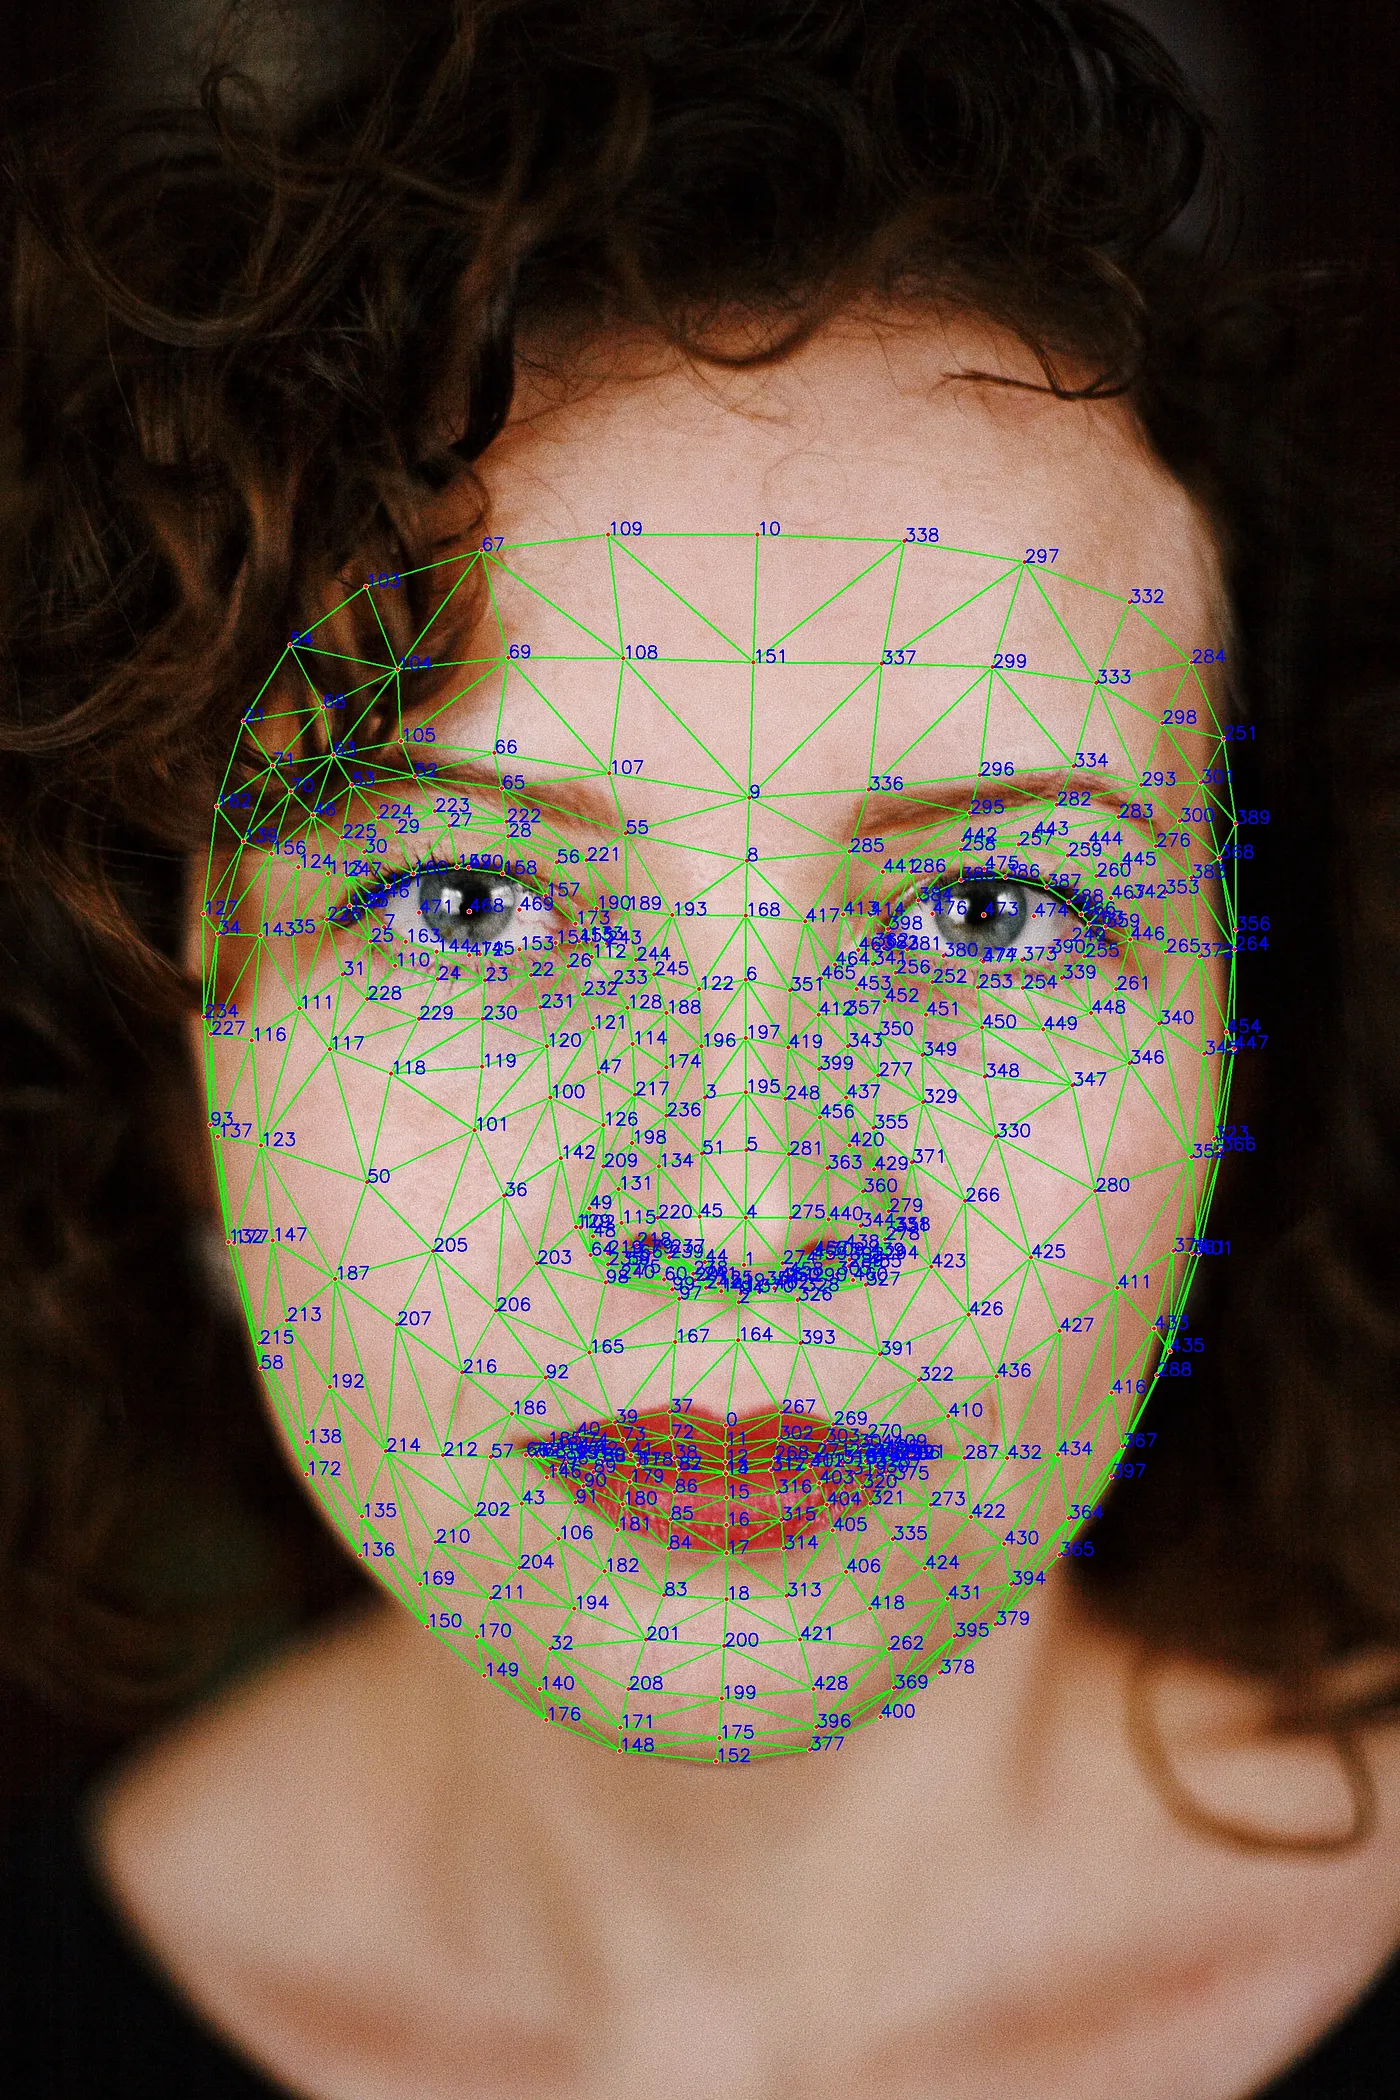

In [ ]:
# landmarks = [0,4, 8,9,10,12,13,14,17 ,109,338,33, 50, 55,58, 61, 127,136,172, 151,152, 159,173,200, 234, 280,288, 285, 291, 356,359,365, 386,397,398, 454]
# sorted_landmarks = sorted(landmarks)
# print(sorted_landmarks)

In [ ]:
landmarks = [ 4,152,0 ,8, 9, 10, 12, 13, 14, 17, 33, 50, 55, 58, 61, 109, 127, 136, 151, 152, 159, 172, 173, 200, 234, 280, 285, 288, 291, 338, 356, 359, 365, 386, 397, 398, 454]
len(landmarks)

37

In [ ]:
# mp_face_mesh = mp.solutions.face_mesh(static_image_mode=True)
mp_face_mesh = mp.solutions.face_mesh

aflw2000_path = '/content/drive/MyDrive/AFLW2000'

def process_images(file_names):
    x_points, y_points, labels, detected_files = [], [], [], []

    for filename in file_names:
        with mp_face_mesh.FaceMesh(static_image_mode=True) as face_mesh:
            image = cv2.imread(f'{aflw2000_path}/{filename}.jpg')
            # Process
            results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

            if results.multi_face_landmarks is not None:
                detected_files.append(filename)
                face_landmarks = results.multi_face_landmarks[0]

                X, Y = [], []
                for i in landmarks:
                    landmark = face_landmarks.landmark[i]
                    relative_x = int(landmark.x * image.shape[1])
                    relative_y = int(landmark.y * image.shape[0])
                    X.append(relative_x)
                    Y.append(relative_y)

                # Subtract all points from the nose point
                nose_x, nose_y = X[0], Y[0]
                X = [x - nose_x for x in X]
                Y = [y - nose_y for y in Y]

                # Normalize each point according to the distance from the nose to the chin
                nose_to_chin = np.sqrt((X[1] - nose_x)**2 + (Y[1] - nose_y)**2)
                X = [x / nose_to_chin for x in X]
                Y = [y / nose_to_chin for y in Y]

                x_points.append(np.array(X))
                y_points.append(np.array(Y))

                mat_file = sio.loadmat(f'{aflw2000_path}/{filename}.mat')
                pose_para = mat_file["Pose_Para"][0][:3]
                labels.append(pose_para)

    return np.array(x_points), np.array(y_points), np.array(labels), detected_files

file_names = sorted([Path(f).stem for f in glob(f"{aflw2000_path}/*.mat")])
x_points, y_points, labels, detected_files = process_images(file_names)

pitch_label = labels[:, 0]
yaw_label = labels[:, 1]
roll_label = labels[:, 2]

# Combine x_points and y_points as features
features = np.concatenate((x_points, y_points), axis=1)

# Combine pitch, yaw, and roll as labels
labels = np.column_stack((pitch_label, yaw_label, roll_label))

# Combine features and labels into one DataFrame
# df = pd.DataFrame(np.column_stack((features,labels)))
df = pd.DataFrame(np.column_stack((features,labels)), columns=[f'landmark_{i}' for i in range(features.shape[1])] + ['pitch', 'yaw', 'roll'])


# Save DataFrame to CSV
df.to_csv("features_and_labels.csv", index=False)


In [ ]:
df = pd.read_csv('features_and_labels.csv', index_col=False)


In [ ]:
df

landmark_0  landmark_1  landmark_2  landmark_3  landmark_4  landmark_5  \
0            0.0   -0.010331   -0.006887    0.027549    0.030993    0.048211   
1            0.0    0.139306    0.046435    0.109756    0.105535    0.135085   
2            0.0   -0.006043   -0.003022   -0.009065   -0.009065   -0.012087   
3            0.0    0.202892    0.072735   -0.042110   -0.057422   -0.091876   
4            0.0    0.113831    0.040654   -0.036588   -0.044719   -0.077242   
...          ...         ...         ...         ...         ...         ...   
1848         0.0   -0.068470   -0.028010   -0.021786   -0.018674   -0.021786   
1849         0.0   -0.080185   -0.032668   -0.014849   -0.011879   -0.005940   
1850         0.0   -0.095845   -0.031009    0.033828    0.045104    0.070474   
1851         0.0   -0.043100   -0.016577    0.023208    0.026523    0.046415   
1852         0.0   -0.003605    0.003605   -0.010816   -0.010816   -0.014422   

      landmark_6  landmark_7  landmark_8  landmark_9  ...  landmark_67  \
0      -0.006887   -0.006887   -0.010331   -0.013775  ...    -0.258275   
1       0.059100    0.067542    0.067542    0.063321  ...    -0.101314   
2      -0.006043   -0.006043   -0.006043   -0.006043  ...    -0.072519   
3       0.088048    0.095704    0.099532    0.114845  ...    -0.394300   
4       0.048785    0.052850    0.056915    0.065046  ...    -0.231726   
...          ...         ...         ...         ...  ...          ...   
1848   -0.031123   -0.037347   -0.034235   -0.037347  ...    -0.183623   
1849   -0.038608   -0.041578   -0.041578   -0.047517  ...    -0.193039   
1850   -0.036647   -0.039466   -0.045104   -0.056379  ...    -0.050741   
1851   -0.019892   -0.023208   -0.019892   -0.026523  ...    -0.212185   
1852    0.003605    0.000000    0.000000    0.003605  ...    -0.126190   

      landmark_68  landmark_69  landmark_70  landmark_71  landmark_72  \
0       -0.227282     0.175627    -0.254832     0.117085    -0.223839   
1       -0.135085     0.291277    -0.164635     0.253284    -0.143528   
2       -0.072519     0.084606    -0.078563     0.063455    -0.072519   
3       -0.313909     0.057422    -0.313909    -0.015313    -0.252659   
4       -0.235792     0.260184    -0.256119     0.199203    -0.211400   
...           ...          ...          ...          ...          ...   
1848    -0.174287     0.152501    -0.196072     0.108929    -0.168062   
1849    -0.181160     0.145522    -0.198979     0.100974    -0.175220   
1850    -0.073293     0.231156    -0.101483     0.200147    -0.093026   
1851    -0.195608     0.195608    -0.225446     0.145877    -0.198923   
1852    -0.158639     0.288435    -0.187483     0.245170    -0.158639   

      landmark_73     pitch       yaw      roll  
0       -0.192846 -0.399231  0.018227  0.085676  
1       -0.029550  0.470065  1.189533  0.300959  
2       -0.048346 -0.184650  0.881137 -0.236852  
3       -0.329222 -0.175379  0.299208 -0.373374  
4       -0.150419 -0.026812  0.011965 -0.220662  
...           ...       ...       ...       ...  
1848    -0.130715 -0.306358 -0.283822  0.038554  
1849    -0.142552 -0.367547 -0.429723  0.122791  
1850    -0.002819 -0.156035  0.567114 -0.108536  
1851    -0.145877 -0.197102 -0.070430  0.105118  
1852    -0.054082 -0.015552 -0.180126 -0.024546  

[1853 rows x 77 columns]

In [ ]:

def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 50):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),3)

    return img

37


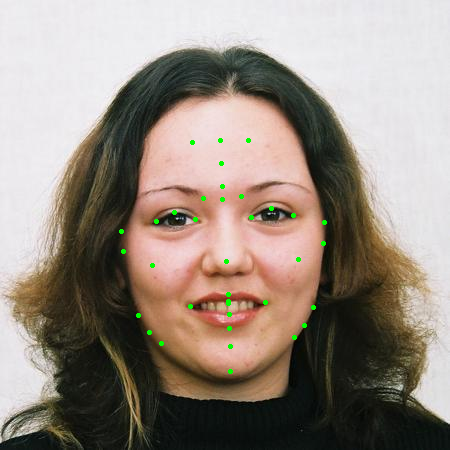

In [ ]:
print(len(landmarks))
with mp.solutions.face_mesh.FaceMesh(static_image_mode=True) as face_mesh:
    image = cv2.imread('/content/drive/MyDrive/AFLW2000/image00044.jpg')
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for idx, landmark in enumerate(face_landmarks.landmark):
                if idx in landmarks:
                    x = int(landmark.x * image.shape[1])
                    y = int(landmark.y * image.shape[0])
                    cv2.circle(image, (x, y), radius=1, color=(0, 255, 0), thickness=2)
        cv2_imshow(image)


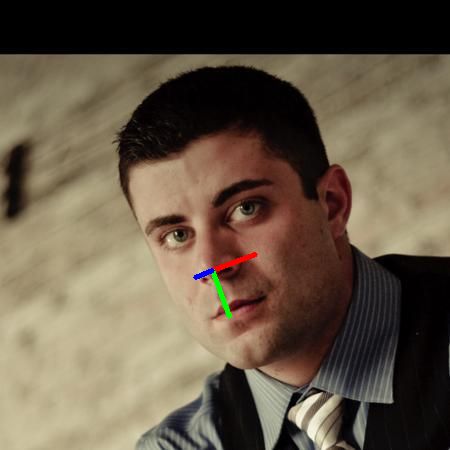

In [ ]:
image = cv2.imread('/content/drive/MyDrive/AFLW2000/image00023.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/drive/MyDrive/AFLW2000/image00023.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
# Run the face detection on the image
faceModule = mp.solutions.face_mesh
mp_face_detection = mp.solutions.face_detection
face_detection = mp.solutions.face_detection.FaceDetection(min_detection_confidence=0.5)
detected_faces = face_detection.process(image)

# Check if any faces were detected
if detected_faces.detections:
    # Loop over the detected faces
    for face in detected_faces.detections:
        # Get the relative keypoints for the face
        keypoints = face.location_data.relative_keypoints
        # Get the x and y position of the nose
        nose_x = int(keypoints[2].x * image.shape[1])
        nose_y = int(keypoints[2].y * image.shape[0])
cv2_imshow(draw_axis(image,pitch,yaw,roll,nose_x,nose_y))

# Split data

In [ ]:
# data = pd.read_csv('/content/feature_and_labels.csv')
data=df
# Split the data into features (X) and labels (y)
X = data.drop(['pitch', 'yaw', 'roll'], axis=1)
y = data[['pitch', 'yaw', 'roll']]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=101)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=101)
print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_val)}")
print(f"Number of testing samples: {len(X_test)}")


Number of training samples: 1482
Number of validation samples: 185
Number of testing samples: 186


In [ ]:
X_train.shape

(1482, 74)

# ***`get the best model by `***

In [ ]:
# Define the parameter grid
param_grid = {
    'kernel': ['rbf'],
    'C': [ 3 ,5, 10, 15, 20,30,50, 100],
    'epsilon': [0.1, 0.01, 0.001]
}


# Create  SVR models
p_svr = SVR()
y_svr = SVR()
r_svr = SVR()

# Create  GridSearchCV  for each model
p_grid_search = GridSearchCV(p_svr, param_grid)
y_grid_search = GridSearchCV(y_svr, param_grid)
r_grid_search = GridSearchCV(r_svr, param_grid)

# Fit the models
p_grid_search.fit(X_train, y_train['pitch'])
y_grid_search.fit(X_train, y_train['yaw'])
r_grid_search.fit(X_train, y_train['roll'])

# Get the best parameters and best scores
print("Best parameters for pitch SVR:", p_grid_search.best_params_)
print("Best parameters for yaw SVR:", y_grid_search.best_params_)
print("Best parameters for roll SVR:", r_grid_search.best_params_)


Best parameters for pitch SVR: {'C': 3, 'epsilon': 0.001, 'kernel': 'rbf'}
Best parameters for yaw SVR: {'C': 3, 'epsilon': 0.01, 'kernel': 'rbf'}
Best parameters for roll SVR: {'C': 3, 'epsilon': 0.01, 'kernel': 'rbf'}


In [ ]:
# Train final SVR models with best parameters
svr_pitch = SVR(C=15,kernel='rbf')
svr_pitch.fit(X_train, y_train['pitch'])

svr_yaw = SVR(**y_grid_search.best_params_)
svr_yaw.fit(X_train, y_train['yaw'])

svr_roll = SVR(**r_grid_search.best_params_)
svr_roll.fit(X_train, y_train['roll'])



SVR(C=3, epsilon=0.01)

In [ ]:

y_pred_pitch = svr_pitch.predict(X_test)
mse_pitch = mean_squared_error(y_test['pitch'], y_pred_pitch)
print(f"Mean Squared Error for pitch on test set: {mse_pitch}")

y_pred_yaw = svr_yaw.predict(X_test)
mse_yaw = mean_squared_error(y_test['yaw'], y_pred_yaw)
print(f"Mean Squared Error for yaw on test set: {mse_yaw}")

y_pred_roll = svr_roll.predict(X_test)
mse_roll = mean_squared_error(y_test['roll'], y_pred_roll)
print(f"Mean Squared Error for roll on test set: {mse_roll}")

y_pred_pitch = svr_pitch.predict(X_val)
mse_pitch = mean_squared_error(y_val['pitch'], y_pred_pitch)
print(f"Mean Squared Error for pitch on val set: {mse_pitch}")

y_pred_yaw = svr_yaw.predict(X_val)
mse_yaw = mean_squared_error(y_val['yaw'], y_pred_yaw)
print(f"Mean Squared Error for yaw on val set: {mse_yaw}")

y_pred_roll = svr_roll.predict(X_val)
mse_roll = mean_squared_error(y_val['roll'], y_pred_roll)
print(f"Mean Squared Error for roll on val set: {mse_roll}")


Mean Squared Error for pitch on test set: 0.018622941549843414
Mean Squared Error for yaw on test set: 0.01721519253953881
Mean Squared Error for roll on test set: 0.010743122411368329
Mean Squared Error for pitch on val set: 0.024495250464543376
Mean Squared Error for yaw on val set: 0.02620452626407253
Mean Squared Error for roll on val set: 0.03928305420532536


In [ ]:
# Calculate the score for the train data
p_train_score = svr_pitch.score(X_train, y_train['pitch'])
y_train_score = svr_yaw.score(X_train, y_train['yaw'])
r_train_score = svr_roll.score(X_train, y_train['roll'])

# Calculate the score for the validation data
p_val_score = svr_pitch.score(X_val, y_val['pitch'])
y_val_score = svr_yaw.score(X_val, y_val['yaw'])
r_val_score = svr_roll.score(X_val, y_val['roll'])

# Calculate the score for the test data
p_test_score = svr_pitch.score(X_test, y_test['pitch'])
y_test_score = svr_yaw.score(X_test, y_test['yaw'])
r_test_score = svr_roll.score(X_test, y_test['roll'])

# Print the scores
print(f"Score for pitch on train_ data: {p_train_score}")
print(f"Score for yaw on train_ data: {y_train_score}")
print(f"Score for roll on train_ data: {r_train_score}")

print(f"Score for pitch on validation data: {p_val_score}")
print(f"Score for yaw on validation data: {y_val_score}")
print(f"Score for roll on validation data: {r_val_score}")

# Print the scores
print(f"Score for pitch on test data: {p_test_score}")
print(f"Score for yaw on test data: {y_test_score}")
print(f"Score for roll on test data: {r_test_score}")




Score for pitch on train_ data: 0.1798897009960857
Score for yaw on train_ data: 0.8561069010658253
Score for roll on train_ data: 0.28193843074065394
Score for pitch on validation data: 0.7208911072626631
Score for yaw on validation data: 0.9212715213762002
Score for roll on validation data: 0.6611632499870648
Score for pitch on test data: 0.7369111593563615
Score for yaw on test data: 0.9441708986142341
Score for roll on test data: 0.8953785021146647


In [ ]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error

# # Define the parameter grid
# param_grid = {
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [100, 500, 1000],
#     'max_depth': [3, 5, 7]
# }

# # Create separate XGBRegressor models for each target
# p_xgb = xgb.XGBRegressor()
# y_xgb = xgb.XGBRegressor()
# r_xgb = xgb.XGBRegressor()

# # Create separate GridSearchCV instances for each target
# p_grid_search = GridSearchCV(p_xgb, param_grid, cv=5)
# y_grid_search = GridSearchCV(y_xgb, param_grid, cv=5)
# r_grid_search = GridSearchCV(r_xgb, param_grid, cv=5)

# # Fit the models
# p_grid_search.fit(X_train, y_train['pitch'])
# y_grid_search.fit(X_train, y_train['yaw'])
# r_grid_search.fit(X_train, y_train['roll'])

# # Get the best parameters and best scores
# print("Best parameters for pitch XGBRegressor:", p_grid_search.best_params_)
# print("Best parameters for yaw XGBRegressor:", y_grid_search.best_params_)
# print("Best parameters for roll XGBRegressor:", r_grid_search.best_params_)


In [ ]:
# # Evaluate the best models on the validation set and test set
# from sklearn.metrics import mean_squared_error

# # Predict on the validation set
# y_val_pred_pitch = pitch_grid_search.best_estimator_.predict(X_val)
# y_val_pred_yaw = yaw_grid_search.best_estimator_.predict(X_val)
# y_val_pred_roll = roll_grid_search.best_estimator_.predict(X_val)

# # Calculate RMSE on the validation set
# rmse_val_pitch = mean_squared_error(y_val['pitch'], y_val_pred_pitch, squared=False)
# rmse_val_yaw = mean_squared_error(y_val['yaw'], y_val_pred_yaw, squared=False)
# rmse_val_roll = mean_squared_error(y_val['roll'], y_val_pred_roll, squared=False)

# print("RMSE for pitch XGBoost on validation set:", rmse_val_pitch)
# print("RMSE for yaw XGBoost on validation set:", rmse_val_yaw)
# print("RMSE for roll XGBoost on validation set:", rmse_val_roll)

# # Predict on the test set
# y_test_pred_pitch = pitch_grid_search.best_estimator_.predict(X_test)
# y_test_pred_yaw = yaw_grid_search.best_estimator_.predict(X_test)
# y_test_pred_roll = roll_grid_search.best_estimator_.predict(X_test)

# # Calculate RMSE on the test set
# rmse_test_pitch = mean_squared_error(y_test['pitch'], y_test_pred_pitch, squared=False)
# rmse_test_yaw = mean_squared_error(y_test['yaw'], y_test_pred_yaw, squared=False)
# rmse_test_roll = mean_squared_error(y_test['roll'], y_test_pred_roll, squared=False)

# print("RMSE for pitch XGBoost on test set:", rmse_test_pitch)
# print("RMSE for yaw XGBoost on test set:", rmse_test_yaw)
# print("RMSE for roll XGBoost on test set:", rmse_test_roll)


In [ ]:
# Save the SVR models to pickle files
with open('svr_pitch.pkl', 'wb') as f:
    pickle.dump(svr_pitch, f)

with open('svr_yaw.pkl', 'wb') as f:
    pickle.dump(svr_yaw, f)

with open('svr_roll.pkl', 'wb') as f:
    pickle.dump(svr_roll, f)

# DRAW

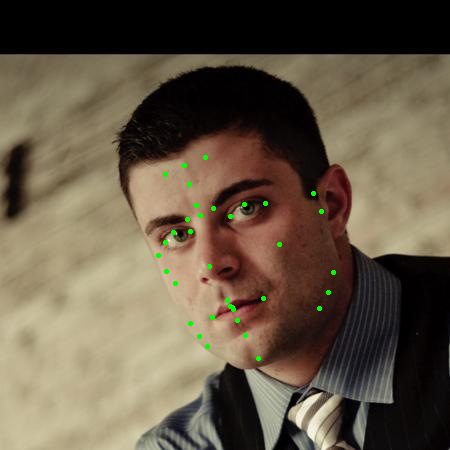

In [ ]:


# List of selected landmark indices
mp_face_mesh = mp.solutions.face_mesh

with mp.solutions.face_mesh.FaceMesh(static_image_mode=False) as face_mesh:
    image = cv2.imread('/content/drive/MyDrive/AFLW2000/image00023.jpg')
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for idx, landmark in enumerate(face_landmarks.landmark):
                if idx in landmarks:
                    x = int(landmark.x * image.shape[1])
                    y = int(landmark.y * image.shape[0])
                    cv2.circle(image, (x, y), radius=1, color=(0, 255, 0), thickness=2)
        cv2_imshow(image)


In [ ]:

# Load the SVR models from the pickle files
with open('svr_pitch.pkl', 'rb') as f:
    svr_pitch = pickle.load(f)

with open('svr_yaw.pkl', 'rb') as f:
    svr_yaw = pickle.load(f)

with open('svr_roll.pkl', 'rb') as f:
    svr_roll = pickle.load(f)


(1, 74)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


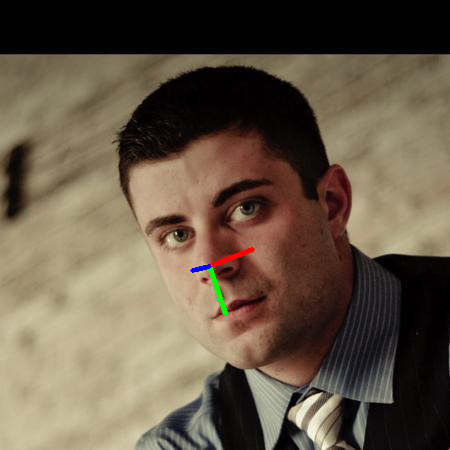

In [ ]:
# Load an image
image = cv2.imread('/content/drive/MyDrive/AFLW2000/image00023.jpg')

# Process the image to get the landmarks
with mp_face_mesh.FaceMesh(static_image_mode=False) as face_mesh:
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


if results.multi_face_landmarks is not None:
    face_landmarks = results.multi_face_landmarks[0]

    X, Y = [], []
    for i in landmarks:
        landmark = face_landmarks.landmark[i]
        relative_x = int(landmark.x * image.shape[1])
        relative_y = int(landmark.y * image.shape[0])
        X.append(relative_x)
        Y.append(relative_y)

    # Subtract all points from the nose point
    nose_x, nose_y = X[0], Y[0]
    X = [x - nose_x for x in X]
    Y = [y - nose_y for y in Y]

    # Normalize each point according to the distance from the nose to the chin
    nose_to_chin = np.sqrt((X[1] - nose_x)**2 + (Y[1] - nose_y)**2)
    X = [x / nose_to_chin for x in X]
    Y = [y / nose_to_chin for y in Y]

    # Predict the pitch, yaw, and roll
    features = np.concatenate((X, Y)).reshape(1,-1)
    print(features.shape)
    pitch = svr_pitch.predict(features)[0]
    yaw = svr_yaw.predict(features)[0]
    roll = svr_roll.predict(features)[0]

    # Draw lines on the image
    image = draw_axis(image, pitch,yaw, roll, tdx=nose_x, tdy=nose_y, size=50)

# Display the image
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()


(1, 74)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


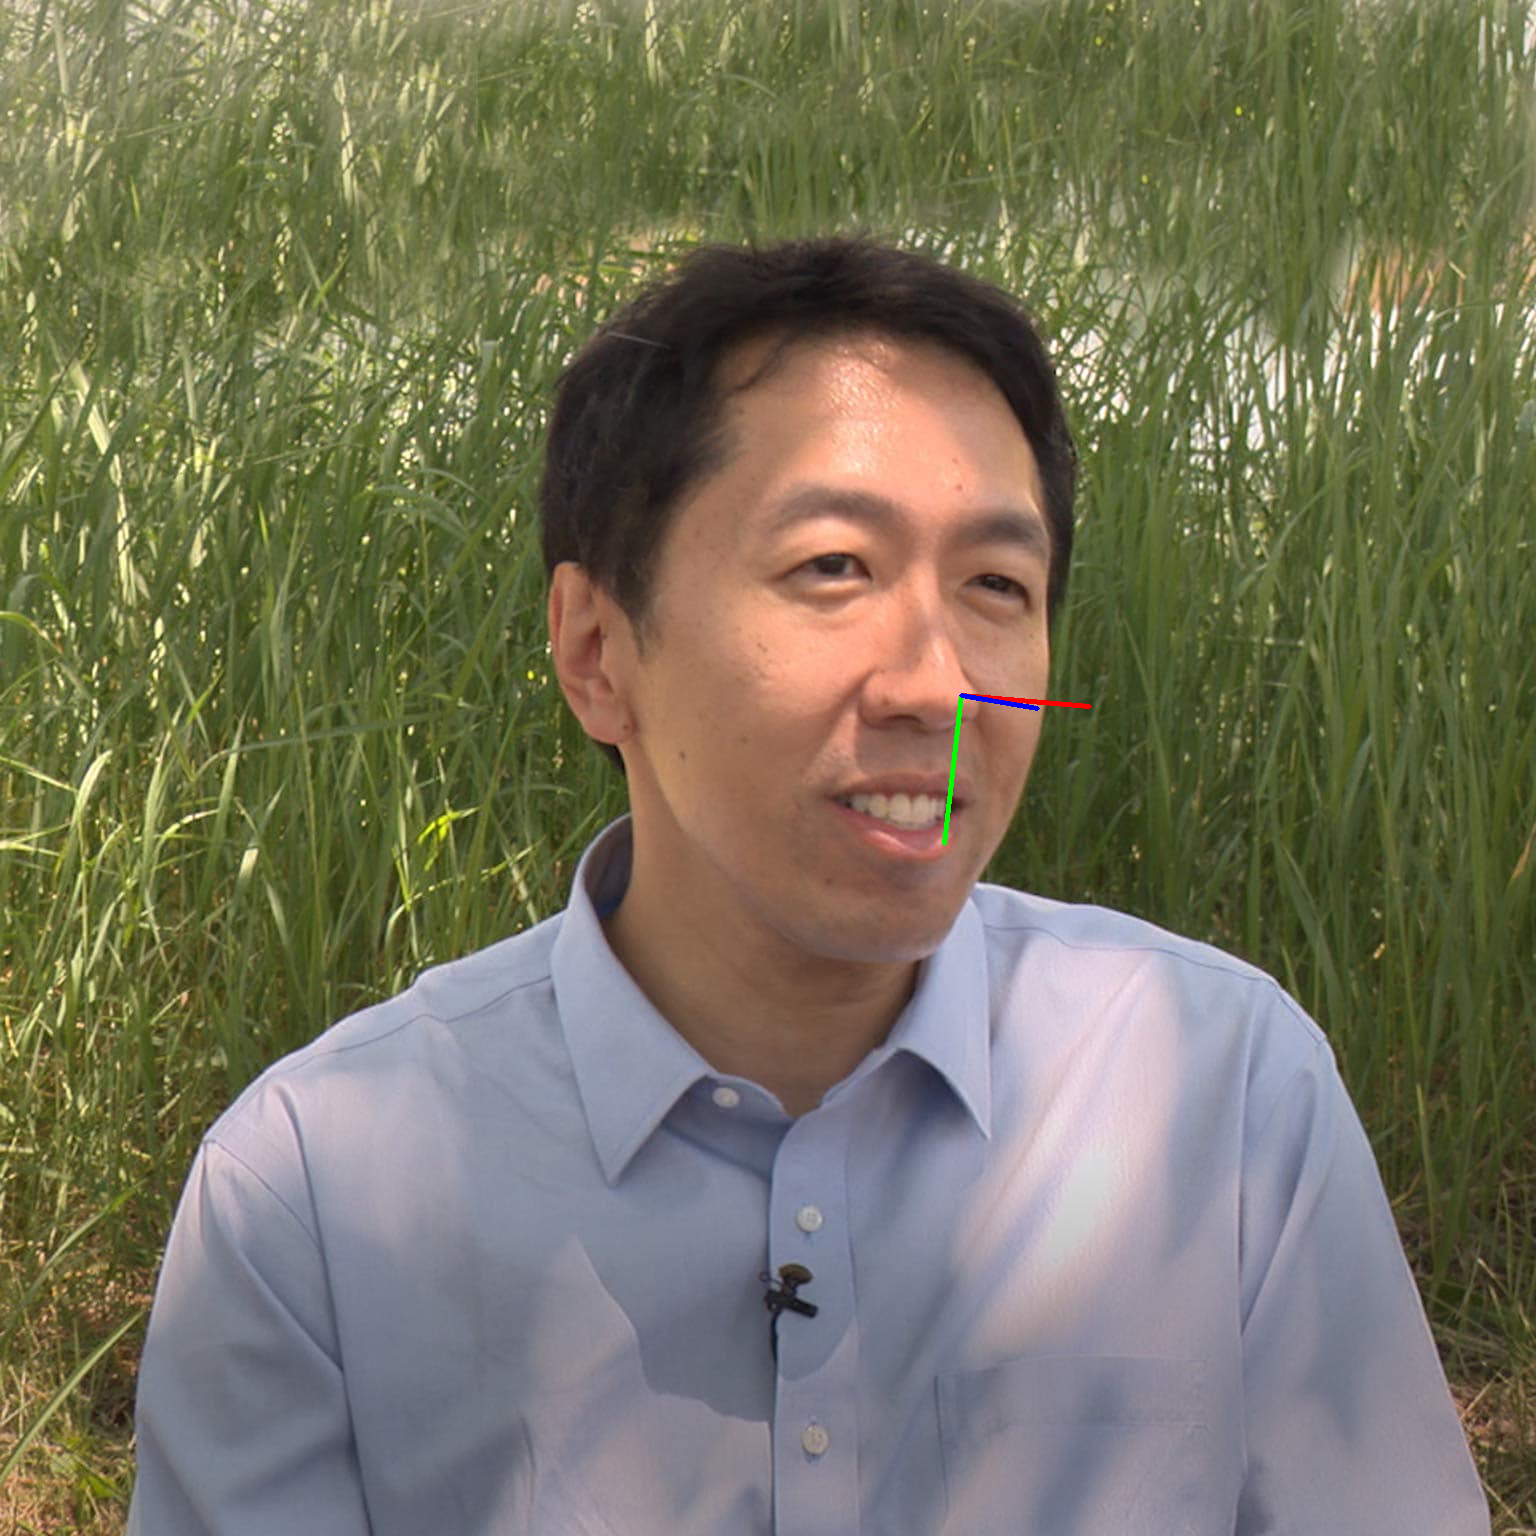

In [ ]:
# Load an image
image = cv2.imread('/content/an_ng.jpg')

# Process the image to get the landmarks
with mp_face_mesh.FaceMesh(static_image_mode=False) as face_mesh:
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


if results.multi_face_landmarks is not None:
    face_landmarks = results.multi_face_landmarks[0]

    X, Y = [], []
    for i in landmarks:
        landmark = face_landmarks.landmark[i]
        relative_x = int(landmark.x * image.shape[1])
        relative_y = int(landmark.y * image.shape[0])
        X.append(relative_x)
        Y.append(relative_y)

    # Subtract all points from the nose point
    nose_x, nose_y = X[0], Y[0]
    X = [x - nose_x for x in X]
    Y = [y - nose_y for y in Y]

    # Normalize each point according to the distance from the nose to the chin
    nose_to_chin = np.sqrt((X[1] - nose_x)**2 + (Y[1] - nose_y)**2)
    X = [x / nose_to_chin for x in X]
    Y = [y / nose_to_chin for y in Y]

    # Predict the pitch, yaw, and roll
    features = np.concatenate((X, Y)).reshape(1,-1)
    print(features.shape)
    pitch = svr_pitch.predict(features)[0]
    yaw = svr_yaw.predict(features)[0]
    roll = svr_roll.predict(features)[0]

    # Draw lines on the image
    image = draw_axis(image, pitch,yaw, roll, tdx=nose_x, tdy=nose_y, size=150)

# Display the image
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()


(1, 74)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


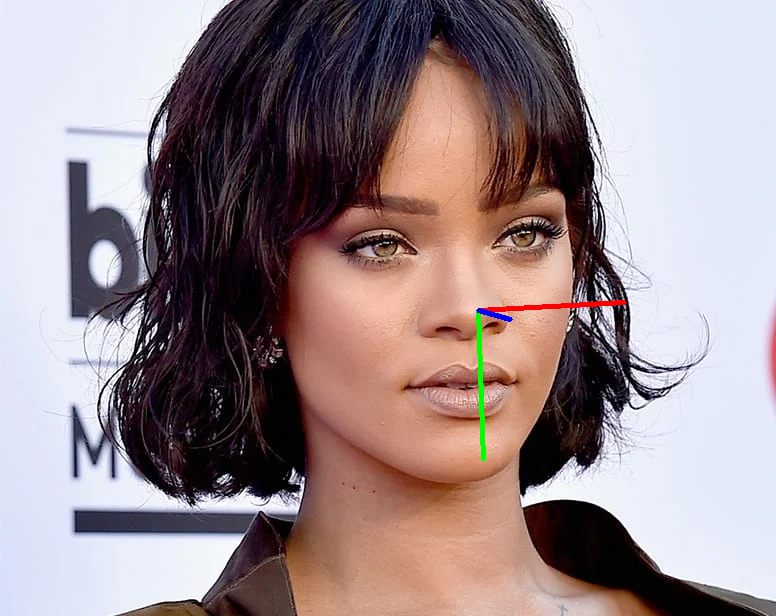

In [84]:
# Load an image
image = cv2.imread('/content/img1.jpg')

# Process the image to get the landmarks
with mp_face_mesh.FaceMesh(static_image_mode=False) as face_mesh:
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


if results.multi_face_landmarks is not None:
    face_landmarks = results.multi_face_landmarks[0]

    X, Y = [], []
    for i in landmarks:
        landmark = face_landmarks.landmark[i]
        relative_x = int(landmark.x * image.shape[1])
        relative_y = int(landmark.y * image.shape[0])
        X.append(relative_x)
        Y.append(relative_y)

    # Subtract all points from the nose point
    nose_x, nose_y = X[0], Y[0]
    X = [x - nose_x for x in X]
    Y = [y - nose_y for y in Y]

    # Normalize each point according to the distance from the nose to the chin
    nose_to_chin = np.sqrt((X[1] - nose_x)**2 + (Y[1] - nose_y)**2)
    X = [x / nose_to_chin for x in X]
    Y = [y / nose_to_chin for y in Y]

    # Predict the pitch, yaw, and roll
    features = np.concatenate((X, Y)).reshape(1,-1)
    print(features.shape)
    pitch = svr_pitch.predict(features)[0]
    yaw = svr_yaw.predict(features)[0]
    roll = svr_roll.predict(features)[0]

    # Draw lines on the image
    image = draw_axis(image, pitch,yaw, roll, tdx=nose_x, tdy=nose_y, size=150)

# Display the image
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()


(1, 74)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


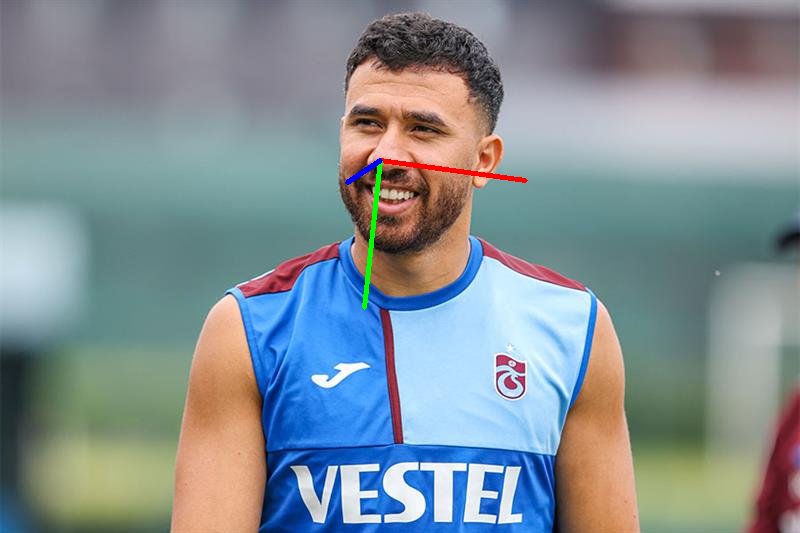

In [85]:
# Load an image
image = cv2.imread('/content/trz.jpg')

# Process the image to get the landmarks
with mp_face_mesh.FaceMesh(static_image_mode=False) as face_mesh:
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


if results.multi_face_landmarks is not None:
    face_landmarks = results.multi_face_landmarks[0]

    X, Y = [], []
    for i in landmarks:
        landmark = face_landmarks.landmark[i]
        relative_x = int(landmark.x * image.shape[1])
        relative_y = int(landmark.y * image.shape[0])
        X.append(relative_x)
        Y.append(relative_y)

    # Subtract all points from the nose point
    nose_x, nose_y = X[0], Y[0]
    X = [x - nose_x for x in X]
    Y = [y - nose_y for y in Y]

    # Normalize each point according to the distance from the nose to the chin
    nose_to_chin = np.sqrt((X[1] - nose_x)**2 + (Y[1] - nose_y)**2)
    X = [x / nose_to_chin for x in X]
    Y = [y / nose_to_chin for y in Y]

    # Predict the pitch, yaw, and roll
    features = np.concatenate((X, Y)).reshape(1,-1)
    print(features.shape)
    pitch = svr_pitch.predict(features)[0]
    yaw = svr_yaw.predict(features)[0]
    roll = svr_roll.predict(features)[0]

    # Draw lines on the image
    image = draw_axis(image, pitch,yaw, roll, tdx=nose_x, tdy=nose_y, size=150)

# Display the image
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()


For example, here we download and display a PNG image of the Colab logo:

In [81]:
# Load the video
video_path = '/content/inputforme.mp4'
cap = cv2.VideoCapture(video_path)

# Create a VideoWriter object to save the output video
output_path = '/content/output_for_me.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Initialize the face mesh model
mp_face_mesh = mp.solutions.face_mesh

# Process each frame of the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Process the image to get the landmarks
    with mp_face_mesh.FaceMesh(static_image_mode=False) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    if results.multi_face_landmarks is not None:
        face_landmarks = results.multi_face_landmarks[0]

        X, Y = [], []
        for i in landmarks:
            landmark = face_landmarks.landmark[i]
            relative_x = int(landmark.x * frame.shape[1])
            relative_y = int(landmark.y * frame.shape[0])
            X.append(relative_x)
            Y.append(relative_y)

        # Subtract all points from the nose point
        nose_x, nose_y = X[0], Y[0]
        X = [x - nose_x for x in X]
        Y = [y - nose_y for y in Y]

        # Normalize each point according to the distance from the nose to the chin
        nose_to_chin = np.sqrt((X[1] - nose_x)**2 + (Y[1] - nose_y)**2)
        X = [x / nose_to_chin for x in X]
        Y = [y / nose_to_chin for y in Y]

        # Predict the pitch, yaw, and roll
        features = np.concatenate((X, Y)).reshape(1,-1)
        pitch = svr_pitch.predict(features)[0]
        yaw = svr_yaw.predict(features)[0]
        roll = svr_roll.predict(features)[0]

        # Draw lines on the image
        frame = draw_axis(frame,pitch, yaw, roll, tdx=nose_x, tdy=nose_y, size=100)

    # Write the frame to the output video
    out.write(frame)
    # cv2_imshow(frame)

# Release the VideoCapture and VideoWriter objects
cap.release()
out.release()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr

In [83]:
# Load the video
video_path = '/content/video_2024-03-10_15-50-06.mp4'
cap = cv2.VideoCapture(video_path)

# Create a VideoWriter object to save the output video
output_path = '/content/output_for_nadim.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Initialize the face mesh model
mp_face_mesh = mp.solutions.face_mesh

# Process each frame of the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Process the image to get the landmarks
    with mp_face_mesh.FaceMesh(static_image_mode=False) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    if results.multi_face_landmarks is not None:
        face_landmarks = results.multi_face_landmarks[0]

        X, Y = [], []
        for i in landmarks:
            landmark = face_landmarks.landmark[i]
            relative_x = int(landmark.x * frame.shape[1])
            relative_y = int(landmark.y * frame.shape[0])
            X.append(relative_x)
            Y.append(relative_y)

        # Subtract all points from the nose point
        nose_x, nose_y = X[0], Y[0]
        X = [x - nose_x for x in X]
        Y = [y - nose_y for y in Y]

        # Normalize each point according to the distance from the nose to the chin
        nose_to_chin = np.sqrt((X[1] - nose_x)**2 + (Y[1] - nose_y)**2)
        X = [x / nose_to_chin for x in X]
        Y = [y / nose_to_chin for y in Y]

        # Predict the pitch, yaw, and roll
        features = np.concatenate((X, Y)).reshape(1,-1)
        pitch = svr_pitch.predict(features)[0]
        yaw = svr_yaw.predict(features)[0]
        roll = svr_roll.predict(features)[0]

        # Draw lines on the image
        frame = draw_axis(frame,pitch, yaw, roll, tdx=nose_x, tdy=nose_y, size=100)

    # Write the frame to the output video
    out.write(frame)
    # cv2_imshow(frame)

# Release the VideoCapture and VideoWriter objects
cap.release()
out.release()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/usr